In [1]:
import os

# set environment variables to limit cpu usage
# os.environ["OMP_NUM_THREADS"] = "4"  # export OMP_NUM_THREADS=4
# os.environ["OPENBLAS_NUM_THREADS"] = "4"  # export OPENBLAS_NUM_THREADS=4
# os.environ["MKL_NUM_THREADS"] = "4"  # export MKL_NUM_THREADS=6
# os.environ["VECLIB_MAXIMUM_THREADS"] = "4"  # export VECLIB_MAXIMUM_THREADS=4
# os.environ["NUMEXPR_NUM_THREADS"] = "4"  # export NUMEXPR_NUM_THREADS=6
os.environ["RAY_OBJECT_STORE_ALLOW_SLOW_STORAGE"] = "1"

from pathlib import Path

import json

import ray
from ray import tune

import torch

from ptmz.loss_landscape.CKA_experiment import CKATrainable

import numpy as np

import pandas as pd

In [25]:
import json
import pandas as pd
from pathlib import Path

def read_json_line(file_path, line_number):
    """
    Read a specific line from a JSON file and return its content.

    Args:
        file_path (str): Path to the JSON file.
        line_number (int): The line number to read (0-based index).

    Returns:
        dict: The parsed JSON object from the specified line.
    """
    with open(file_path, 'r') as f:
        for current_line_number, line in enumerate(f):
            if current_line_number == line_number:
                return json.loads(line)
    raise IndexError(f"Line {line_number} not found in file {file_path}.")

def compile_configs(root_dir, line_number):
    """
    Compile configurations from specific lines of result.json files in the directory structure.

    Args:
        root_dir (str): The root directory containing the configuration directories.
        line_number (int): The line number to read from each result.json file.

    Returns:
        pd.DataFrame: DataFrame of configurations.
    """
    # Create a Path object for the root directory
    root_path = Path(root_dir)

    # List to hold all the configurations and their paths
    data = []

    # Walk through the directory structure
    path_list = [pdx for pdx in root_path.iterdir() if pdx.is_dir()]
    for pdx in path_list:
        json_file = pdx.joinpath('result.json')    
        # Load the specific line from the JSON file
        try:
            result = read_json_line(json_file, line_number)
        except FileNotFoundError:
            print(f"File not found: {json_file}")
            continue
        except IndexError as e:
            print(e)
            continue
        
        # Unroll the 'config' dictionary into the main dictionary
        config = result.pop('config', {})
        result.update(config)
        
        # Append the configuration and the path to the data list
        result["file_path"] = str(json_file).replace("result.json", "")
        data.append(result)

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(data)

    return df

def create_experiment_dataframe(
    model_dataframe,
    vary_keys=["seed"],
    match_keys=["training::batchsize", "model::width"],
):
    """
    Create a DataFrame of experiments to run.

    Args:
        model_dataframe (pd.DataFrame): DataFrame containing the model configurations
        vary_keys (list): list of keys to vary in the experiments
        match_keys (list): list of keys to match in the experiments

    Returns:
        pd.DataFrame: DataFrame of experiments to run with matched configurations and model paths
    """
    
    # Check if input is a DataFrame
    if not isinstance(model_dataframe, pd.DataFrame):
        raise ValueError("The model_dataframe should be a pandas DataFrame.")
    
    # Check if all vary_keys and match_keys are in the DataFrame columns
    for key in vary_keys + match_keys:
        if key not in model_dataframe.columns:
            raise ValueError(f"Key '{key}' not found in DataFrame columns.")
    
    # Group the dataframe by the match_keys
    grouped = model_dataframe.groupby(match_keys)
    
    experiment_list = []
    
    # Iterate over each group
    for match_values, group in grouped:
        # Get the matching part as a dictionary
        match_dict = dict(zip(match_keys, match_values))
        
        # Get the list of file paths for the current group
        model_paths = group['file_path'].tolist()
        
        # Average the numerical columns
        numerical_cols = group.select_dtypes(include='number').columns
        avg_values = group[numerical_cols].mean().to_dict()
        
        # Create a record with matching keys, averaged values, and model paths
        record = {**match_dict, **avg_values, 'model_paths': model_paths}
        
        experiment_list.append(record)
    
    # Convert the list of records to a DataFrame
    experiments_df = pd.DataFrame(experiment_list)
    
    return experiments_df

def mean_of_list(cell):
    """
    Calculate the mean of a list of values in a cell.

    Args:
        cell (list): A list of numerical values.

    Returns:
        float: The mean of the list or NaN if the cell is not a list.
    """
    if isinstance(cell, list):
        try:
            return np.mean(np.array(cell))
        except:
            return np.nan
    return np.nan

def aggregate_results_in_dfs(df,aggregate_keys):
    df_out = df.copy()
    df_out[aggregate_keys] = df[aggregate_keys].applymap(mean_of_list)
    return df_out


import pandas as pd

def merge_dataframes_on_key(dataframes, key):
    """
    Merge a list of DataFrames on a specified key.

    Args:
        dataframes (list): List of pandas DataFrames to merge.
        key (str): The key column to merge on. The column should contain lists.

    Returns:
        pd.DataFrame: Merged DataFrame.
    """
    def convert_to_frozenset(df, column_name):
        df[column_name] = df[column_name].apply(frozenset)
        return df

    # Ensure the key is present in all DataFrames
    for df in dataframes:
        if key not in df.columns:
            raise ValueError(f"Key '{key}' not found in DataFrame columns.")
    
    # Convert the key column to frozenset for merging
    dataframes = [convert_to_frozenset(df, key) for df in dataframes]

    # Merge all DataFrames on the specified key
    merged_df = dataframes[0]
    for df in dataframes[1:]:
        merged_df = pd.merge(merged_df, df, on=key, how='inner')
    
    # Convert frozensets back to lists in the key column
    merged_df[key] = merged_df[key].apply(list)
    
    return merged_df


def read_model_data(
    root_models,
    root_cka,
    root_hessian,
    root_curve,
    root_wiseft,
    epoch=100,
):
    dfs = []
    
    # read model data
    if root_models is not None:
        # read model data
        config_df = compile_configs(root_models,epoch)
        # clean exp config
        keys_to_retain_exp = ['train_loss', 'train_acc', 'test_loss', 'test_acc',
               'training_iteration', 'model::type','model::width',
               'seed',
               'training::batchsize', 'file_path']
        data_df = config_df[keys_to_retain_exp].copy()
        # compute exp config
        exp_df = create_experiment_dataframe(data_df)
        # append output
        print(f'found {len(exp_df)} experiment data')
        dfs.append(exp_df)
    
    # read cka data
    if root_cka is not None:
        # read raw data
        config_cka = compile_configs(root_cka,0)
        # drop unnecessary columns
        keys_to_retain_cka = ['representation_similarity',
               'representation_similarity_pairs', 'model_paths', 'epoch',
               'file_path']
        data_cka = config_cka[keys_to_retain_cka].copy()
        # aggregate repeated values
        cka_aggregate_keys = ["representation_similarity","representation_similarity_pairs"]
        df_cka_clean = aggregate_results_in_dfs(data_cka,cka_aggregate_keys)
        # append
        print(f'found {len(df_cka_clean)} cka data')
        dfs.append(df_cka_clean)
    
    # read hessian data
    if root_hessian is not None:
        config_hessian = compile_configs(root_hessian,0)
        # drop unnecessary columns
        keys_to_retain_hessian = ['hessian_top_eigenvalues_list', 'hessina_trace_list',
               'hessian_top_eigenvalues_mean', 'hessina_trace_mean', 'model_paths',
               'hessian_batch_size', 'hessian_number_batches',
               'file_path']
        data_hessian = config_hessian[keys_to_retain_hessian].copy()
        # compute log eigenvalues
        data_hessian['log_hessian_top_ev'] = np.log(data_hessian['hessian_top_eigenvalues_mean'])
        data_hessian['log_hessian_trace'] = np.log(data_hessian['hessina_trace_mean'])
        # append
        print(f'found {len(data_hessian)} hessian data')
        dfs.append(data_hessian)

    # read curve data
    if root_curve is not None:
        # read data
        config_curve = compile_configs(root_curve,0)
        # extract stats data
        df_curve = unroll_curve_dict(config_curve,"aggregated")
        # clean df
        keys_to_retain_curve = [
               'model_paths', 'epoch', 'file_path', 'mc_train_loss',
               'mc_test_loss', 'mc_train_error', 'mc_test_error']
        data_curve = df_curve[keys_to_retain_curve].copy()    
        # change keys
        new_names = {}
        for key in data_curve.keys():
            if key=='model_paths':
                continue
            new_names[key]=f'curve_{key}'
        data_curve.rename(columns=new_names,inplace=True)
        # append
        print(f'found {len(data_curve)} curve data')
        dfs.append(data_curve)
        
    # read MC data
    if root_wiseft is not None:
        # load raw data
        config_wiseft = compile_configs(root_wiseft,0)
        # get aggregated data
        df_wiseft = unroll_dict(config_wiseft,"aggregated")
        # clean df
        keys_to_retain_wiseft = ['model_paths', 'epoch_list_x',
               'align_models', 'file_path', 'epoch_list_y', 'loss_train', 'loss_test',
               'acc_train', 'acc_test']
        data_wiseft = df_wiseft[keys_to_retain_wiseft].copy()    
        new_names = {}
        for key in data_wiseft.keys():
            if key=='model_paths':
                continue
            new_names[key]=f'wiseft_{key}'
        data_wiseft.rename(columns=new_names,inplace=True)
        # append
        print(f'found {len(data_wiseft)} wiseft data')
        dfs.append(data_wiseft)
    # clean MC data
    
    # merge
    df_merged = merge_dataframes_on_key(dfs, 'model_paths')

    # return
    return df_merged

# Function to unroll the dictionary with lists into separate columns
def unroll_dict(df, dict_column):
    # Create a DataFrame to store the unrolled columns

    dict_list = df[dict_column].to_list()

    aggregated_dict = {}
    for key in dict_list[0].keys():
        aggregated_dict[key] = []
    for ddx in dict_list:
        for key in aggregated_dict.keys():
            aggregated_dict[key].append(ddx[key][0])

    unrolled_df = pd.DataFrame(aggregated_dict)

    merged_df = pd.merge(df, unrolled_df, left_index=True, right_index=True)

    
    return merged_df

# Function to unroll the dictionary with lists into separate columns
def unroll_curve_dict(df, dict_column):
    # Create a DataFrame to store the unrolled columns

    dict_list = df[dict_column].to_list()

    aggregated_dict = {}
    for key in ['train_loss', 'test_loss', 'train_error', 'test_error']:
        new_key = f'mc_{key}'
        aggregated_dict[new_key] = []
    for ddx in dict_list:
        for key in ['train_loss', 'test_loss', 'train_error', 'test_error']:
            new_key = f'mc_{key}'
            aggregated_dict[new_key].append(ddx['mc'][key])
    
    # config_curve.aggregated.tolist()[0]['mc']
    # for key1 in ["stats"]:
    #     for key2 in ["train", "eval"]:
    #         for key3 in dict_list[0][key1][key2].keys():
    #             for sub in ["min", "max", "avg", "int"]:
    #                 new_key = f'{key1}_{key2}_{key3}_{sub}'
    #                 aggregated_dict[new_key] = []
    # for ddx in dict_list:
    #     for key1 in ["stats"]:
    #         for key2 in ["train", "eval"]:
    #             for key3 in dict_list[0][key1][key2].keys():
    #                 for idx, sub in enumerate(["min", "max", "avg", "int"]):
    #                     new_key = f'{key1}_{key2}_{key3}_{sub}'
    #                     aggregimport json
import pandas as pd
from pathlib import Path

def read_json_line(file_path, line_number):
    """
    Read a specific line from a JSON file and return its content.

    Args:
        file_path (str): Path to the JSON file.
        line_number (int): The line number to read (0-based index).

    Returns:
        dict: The parsed JSON object from the specified line.
    """
    with open(file_path, 'r') as f:
        for current_line_number, line in enumerate(f):
            if current_line_number == line_number:
                return json.loads(line)
    raise IndexError(f"Line {line_number} not found in file {file_path}.")

def compile_configs(root_dir, line_number):
    """
    Compile configurations from specific lines of result.json files in the directory structure.

    Args:
        root_dir (str): The root directory containing the configuration directories.
        line_number (int): The line number to read from each result.json file.

    Returns:
        pd.DataFrame: DataFrame of configurations.
    """
    # Create a Path object for the root directory
    root_path = Path(root_dir)

    # List to hold all the configurations and their paths
    data = []

    # Walk through the directory structure
    path_list = [pdx for pdx in root_path.iterdir() if pdx.is_dir()]
    for pdx in path_list:
        json_file = pdx.joinpath('result.json')    
        # Load the specific line from the JSON file
        try:
            result = read_json_line(json_file, line_number)
        except FileNotFoundError:
            print(f"File not found: {json_file}")
            continue
        except IndexError as e:
            print(e)
            continue
        
        # Unroll the 'config' dictionary into the main dictionary
        config = result.pop('config', {})
        result.update(config)
        
        # Append the configuration and the path to the data list
        result["file_path"] = str(json_file).replace("result.json", "")
        data.append(result)

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(data)

    return df

def create_experiment_dataframe(
    model_dataframe,
    vary_keys=["seed"],
    match_keys=["training::batchsize", "model::width"],
):
    """
    Create a DataFrame of experiments to run.

    Args:
        model_dataframe (pd.DataFrame): DataFrame containing the model configurations
        vary_keys (list): list of keys to vary in the experiments
        match_keys (list): list of keys to match in the experiments

    Returns:
        pd.DataFrame: DataFrame of experiments to run with matched configurations and model paths
    """
    
    # Check if input is a DataFrame
    if not isinstance(model_dataframe, pd.DataFrame):
        raise ValueError("The model_dataframe should be a pandas DataFrame.")
    
    # Check if all vary_keys and match_keys are in the DataFrame columns
    for key in vary_keys + match_keys:
        if key not in model_dataframe.columns:
            raise ValueError(f"Key '{key}' not found in DataFrame columns.")
    
    # Group the dataframe by the match_keys
    grouped = model_dataframe.groupby(match_keys)
    
    experiment_list = []
    
    # Iterate over each group
    for match_values, group in grouped:
        # Get the matching part as a dictionary
        match_dict = dict(zip(match_keys, match_values))
        
        # Get the list of file paths for the current group
        model_paths = group['file_path'].tolist()
        
        # Average the numerical columns
        numerical_cols = group.select_dtypes(include='number').columns
        avg_values = group[numerical_cols].mean().to_dict()
        
        # Create a record with matching keys, averaged values, and model paths
        record = {**match_dict, **avg_values, 'model_paths': model_paths}
        
        experiment_list.append(record)
    
    # Convert the list of records to a DataFrame
    experiments_df = pd.DataFrame(experiment_list)
    
    return experiments_df

def mean_of_list(cell):
    """
    Calculate the mean of a list of values in a cell.

    Args:
        cell (list): A list of numerical values.

    Returns:
        float: The mean of the list or NaN if the cell is not a list.
    """
    if isinstance(cell, list):
        try:
            return np.mean(np.array(cell))
        except:
            return np.nan
    return np.nan

def aggregate_results_in_dfs(df,aggregate_keys):
    df_out = df.copy()
    df_out[aggregate_keys] = df[aggregate_keys].applymap(mean_of_list)
    return df_out


import pandas as pd

def merge_dataframes_on_key(dataframes, key):
    """
    Merge a list of DataFrames on a specified key.

    Args:
        dataframes (list): List of pandas DataFrames to merge.
        key (str): The key column to merge on. The column should contain lists.

    Returns:
        pd.DataFrame: Merged DataFrame.
    """
    def convert_to_frozenset(df, column_name):
        df[column_name] = df[column_name].apply(frozenset)
        return df

    # Ensure the key is present in all DataFrames
    for df in dataframes:
        if key not in df.columns:
            raise ValueError(f"Key '{key}' not found in DataFrame columns.")
    
    # Convert the key column to frozenset for merging
    dataframes = [convert_to_frozenset(df, key) for df in dataframes]

    # Merge all DataFrames on the specified key
    merged_df = dataframes[0]
    for df in dataframes[1:]:
        merged_df = pd.merge(merged_df, df, on=key, how='inner')
    
    # Convert frozensets back to lists in the key column
    merged_df[key] = merged_df[key].apply(list)
    
    return merged_df


def read_model_data(
    root_models,
    root_cka,
    root_hessian,
    root_curve,
    root_wiseft,
    root_gitrebasin,
    epoch=100,
):
    dfs = []
    
    # read model data
    if root_models is not None:
        # read model data
        config_df = compile_configs(root_models,epoch)
        # clean exp config
        keys_to_retain_exp = ['train_loss', 'train_acc', 'test_loss', 'test_acc',
               'training_iteration', 'model::type','model::width',
               'seed',
               'training::batchsize', 'file_path']
        data_df = config_df[keys_to_retain_exp].copy()
        # compute exp config
        exp_df = create_experiment_dataframe(data_df)
        # append output
        print(f'found {len(exp_df)} experiment data')
        dfs.append(exp_df)
    
    # read cka data
    if root_cka is not None:
        # read raw data
        config_cka = compile_configs(root_cka,0)
        # drop unnecessary columns
        keys_to_retain_cka = ['representation_similarity',
               'representation_similarity_pairs', 'model_paths', 'epoch',
               'file_path']
        data_cka = config_cka[keys_to_retain_cka].copy()
        # aggregate repeated values
        cka_aggregate_keys = ["representation_similarity","representation_similarity_pairs"]
        df_cka_clean = aggregate_results_in_dfs(data_cka,cka_aggregate_keys)
        # append
        print(f'found {len(df_cka_clean)} cka data')
        dfs.append(df_cka_clean)
    
    # read hessian data
    if root_hessian is not None:
        config_hessian = compile_configs(root_hessian,0)
        # drop unnecessary columns
        keys_to_retain_hessian = ['hessian_top_eigenvalues_train_list', 'hessina_trace_train_list',
               'hessian_top_eigenvalues_train_mean', 'hessian_trace_train_mean', 'hessian_top_eigenvalues_val_list',
               'hessina_trace_val_list', 'hessian_top_eigenvalues_val_mean',
               'hessian_trace_val_mean', 'model_paths',
               'hessian_batch_size', 'hessian_number_batches',
               'file_path']
       
        data_hessian = config_hessian[keys_to_retain_hessian].copy()
        # compute log eigenvalues
        data_hessian['log_hessian_top_ev_train'] = np.log(data_hessian['hessian_top_eigenvalues_train_mean'])
        data_hessian['log_hessian_trace_train'] = np.log(data_hessian['hessian_trace_train_mean'])
        data_hessian['log_hessian_top_ev_val'] = np.log(data_hessian['hessian_top_eigenvalues_val_mean'])
        data_hessian['log_hessian_trace_val'] = np.log(data_hessian['hessian_trace_val_mean'])
        # append
        print(f'found {len(data_hessian)} hessian data')
        dfs.append(data_hessian)

    # read curve data
    if root_curve is not None:
        # read data
        config_curve = compile_configs(root_curve,0)
        # extract stats data
        df_curve = unroll_curve_dict(config_curve,"aggregated")
        # clean df
        keys_to_retain_curve = [
               'model_paths', 'epoch', 'file_path', 'mc_train_loss',
               'mc_test_loss', 'mc_train_error', 'mc_test_error']
        data_curve = df_curve[keys_to_retain_curve].copy()    
        # change keys
        new_names = {}
        for key in data_curve.keys():
            if key=='model_paths':
                continue
            new_names[key]=f'curve_{key}'
        data_curve.rename(columns=new_names,inplace=True)
        # append
        print(f'found {len(data_curve)} curve data')
        dfs.append(data_curve)
        
    # read MC data
    if root_wiseft is not None:
        # load raw data
        config_wiseft = compile_configs(root_wiseft,0)
        # get aggregated data
        df_wiseft = unroll_dict(config_wiseft,"aggregated")
        # clean df
        keys_to_retain_wiseft = ['model_paths', 'epoch_list_x',
               'align_models', 'file_path', 'epoch_list_y', 'loss_train', 'loss_test',
               'acc_train', 'acc_test']
        data_wiseft = df_wiseft[keys_to_retain_wiseft].copy()    
        new_names = {}
        for key in data_wiseft.keys():
            if key=='model_paths':
                continue
            new_names[key]=f'wiseft_{key}'
        data_wiseft.rename(columns=new_names,inplace=True)
        # append
        print(f'found {len(data_wiseft)} wiseft data')
        dfs.append(data_wiseft)

        # read MC data
    if root_gitrebasin is not None:
        # load raw data
        config_gitrebasin = compile_configs(root_gitrebasin,0)
        # clean df
        keys_to_retain_gitrebasin = ['model_paths', 'align_models', 'file_path', 'loss_train', 'loss_test', 'acc_train', 'acc_test']
        data_gitrebasin = config_gitrebasin[keys_to_retain_gitrebasin].copy()    
        # get values out of list
        for key in data_gitrebasin.keys():
            data_gitrebasin[key] = data_gitrebasin[key].apply(extract_single_value)
        # rename
        new_names = {}
        for key in data_gitrebasin.keys():
            if key=='model_paths':
                continue
            new_names[key]=f'gitrebasin_{key}'
        data_gitrebasin.rename(columns=new_names,inplace=True)
        
        # append
        print(f'found {len(data_gitrebasin)} gitrebasin data')
        dfs.append(data_gitrebasin)
    # clean MC data
    
    # merge
    df_merged = merge_dataframes_on_key(dfs, 'model_paths')

    # return
    return df_merged

# Function to unroll the dictionary with lists into separate columns
def unroll_dict(df, dict_column):
    # Create a DataFrame to store the unrolled columns

    dict_list = df[dict_column].to_list()

    aggregated_dict = {}
    for key in dict_list[0].keys():
        aggregated_dict[key] = []
    for ddx in dict_list:
        for key in aggregated_dict.keys():
            aggregated_dict[key].append(ddx[key][0])

    unrolled_df = pd.DataFrame(aggregated_dict)

    merged_df = pd.merge(df, unrolled_df, left_index=True, right_index=True)

    
    return merged_df

# Function to unroll the dictionary with lists into separate columns
def unroll_curve_dict(df, dict_column):
    # Create a DataFrame to store the unrolled columns

    dict_list = df[dict_column].to_list()

    aggregated_dict = {}
    for key in ['train_loss', 'test_loss', 'train_error', 'test_error']:
        new_key = f'mc_{key}'
        aggregated_dict[new_key] = []
    for ddx in dict_list:
        for key in ['train_loss', 'test_loss', 'train_error', 'test_error']:
            new_key = f'mc_{key}'
            aggregated_dict[new_key].append(ddx['mc'][key])
    
    unrolled_df = pd.DataFrame(aggregated_dict)

    merged_df = pd.merge(df, unrolled_df, left_index=True, right_index=True)

    
    return merged_df

def extract_single_value(cell):
    if isinstance(cell, list) and len(cell) == 1:
        return cell[0]
    return cellated_dict[new_key].append(ddx[key1][key2][key3][idx])

    unrolled_df = pd.DataFrame(aggregated_dict)

    merged_df = pd.merge(df, unrolled_df, left_index=True, right_index=True)

    
    return merged_df



In [36]:
epoch = 125
# epoch = 150
root = Path('/ds2/model_zoos/taxonomy/cifar_10/zoos/Cifar-10/Resnet50_width_v2/')
root_zoo = root.joinpath(
        "tune_zoo_cifar-10_Resnet50_width_kaiming_uniform_150eps_width_2-256"
    )
# root_cka = None
root_cka = root.joinpath(
        f"CKA_cifar-10_Resnet50_width_kaiming_uniform_{epoch}eps_width_2-256"
    )
root_hessian = None
# root_hessian = root.joinpath(
#         f"hessian_cifar-10_Resnet50_width_kaiming_uniform_{epoch}eps_width_2-256"
#     )
root_curve = None
root_curve = root.joinpath(
        f"curve_cifar-10_Resnet50_width_kaiming_uniform_{epoch}eps_width_2-256_bs128"
    )
root_wiseft = None
# root_wiseft = root.joinpath( 
#         f"model_average_epochs_cifar-10_Resnet50_width_kaiming_uniform_{epoch}eps_width_2-256"
#     )
root_gitrebasin = None
# root_gitrebasin = root.joinpath( 
#         f"model_average_seeds_cifar-10_Resnet50_width_kaiming_uniform_{epoch}eps_width_2-256"
#     )


In [37]:
df_merged = read_model_data(
    root_models=root_zoo,
    root_cka=root_cka,
    root_hessian=root_hessian,
    root_curve=root_curve,
    root_wiseft=root_wiseft,
    root_gitrebasin=root_gitrebasin, 
    epoch=epoch,
)

found 63 experiment data
found 56 cka data
File not found: /ds2/model_zoos/taxonomy/cifar_10/zoos/Cifar-10/Resnet50_width_v2/curve_cifar-10_Resnet50_width_kaiming_uniform_125eps_width_2-256_bs128/CurveTrainable_b1451_00061_61_model_paths=ds2_model_zoos_taxonomy_cifar_10_zoos_Cifar-10_Resnet50_width_v2_tune_zoo_cifar-10_Resne_2024-06-07_23-54-38/result.json
File not found: /ds2/model_zoos/taxonomy/cifar_10/zoos/Cifar-10/Resnet50_width_v2/curve_cifar-10_Resnet50_width_kaiming_uniform_125eps_width_2-256_bs128/CurveTrainable_b1451_00063_63_model_paths=ds2_model_zoos_taxonomy_cifar_10_zoos_Cifar-10_Resnet50_width_v2_tune_zoo_cifar-10_Resne_2024-06-08_00-40-43/result.json
File not found: /ds2/model_zoos/taxonomy/cifar_10/zoos/Cifar-10/Resnet50_width_v2/curve_cifar-10_Resnet50_width_kaiming_uniform_125eps_width_2-256_bs128/CurveTrainable_b1451_00058_58_model_paths=ds2_model_zoos_taxonomy_cifar_10_zoos_Cifar-10_Resnet50_width_v2_tune_zoo_cifar-10_Resne_2024-06-07_22-27-42/result.json
File not 

In [38]:
df_merged.keys()

Index(['training::batchsize', 'model::width', 'train_loss', 'train_acc',
       'test_loss', 'test_acc', 'training_iteration', 'seed', 'model_paths',
       'representation_similarity', 'representation_similarity_pairs', 'epoch',
       'file_path', 'curve_epoch', 'curve_file_path', 'curve_mc_train_loss',
       'curve_mc_test_loss', 'curve_mc_train_error', 'curve_mc_test_error'],
      dtype='object')

In [39]:
if root_wiseft is not None: 
    df_merged['wiseft_acc_train_delta'] = df_merged['wiseft_acc_train']-df_merged['train_acc']
    df_merged['wiseft_acc_test_delta'] = df_merged['wiseft_acc_test']-df_merged['test_acc']
    df_merged['wiseft_loss_train_delta'] = df_merged['wiseft_loss_train']-df_merged['train_loss']
    df_merged['wiseft_loss_test_delta'] = df_merged['wiseft_loss_test']-df_merged['test_loss']
df_merged['ggap'] = df_merged['test_acc']-df_merged['train_acc']
df_merged['training::batchsize'] = df_merged['training::batchsize'].astype('int')
df_merged['model::width'] = df_merged['model::width'].astype('int')

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# fig_list = ["test_acc","train_loss","representation_similarity", "log_hessian_top_ev","log_hessian_trace",'curve_mc_train_loss', 'curve_mc_test_loss','curve_mc_train_error', 'curve_mc_test_error','wiseft_acc_train_delta','wiseft_acc_test_delta','wiseft_loss_train_delta','wiseft_loss_test_delta']
# fig_list = ["test_acc","train_loss","representation_similarity", "log_hessian_top_ev","log_hessian_trace",'wiseft_acc_train_delta','wiseft_acc_test_delta','wiseft_loss_train_delta','wiseft_loss_test_delta']
# fig_list = ["test_acc","train_loss","representation_similarity", "log_hessian_top_ev","log_hessian_trace",]
# fig_list = ["test_acc","train_loss","representation_similarity",'wiseft_acc_test_delta','wiseft_loss_train_delta','wiseft_loss_test_delta','ggap']
fig_list = ["test_acc","train_loss",'ggap']

num_cols = 4
num_plots = len(fig_list)
num_rows = int(np.ceil(num_plots / num_cols))


fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows,figsize=(5*num_cols,5*num_rows),dpi=300)

axes = ax.flatten()

for idx,fig_key in enumerate(fig_list):
    
    df_fig = df_merged.pivot_table(index='training::batchsize', columns='model::width', values=fig_key)

    # Create the heatmap
    adx = axes[idx]
    sns.heatmap(df_fig, annot=True, cmap='viridis', cbar=True,ax=adx)
    adx.set_title(f'{fig_key}')
    adx.set_xlabel('Model Width')
    adx.set_ylabel('Training Batch Size')

fig.tight_layout()
plt.show()


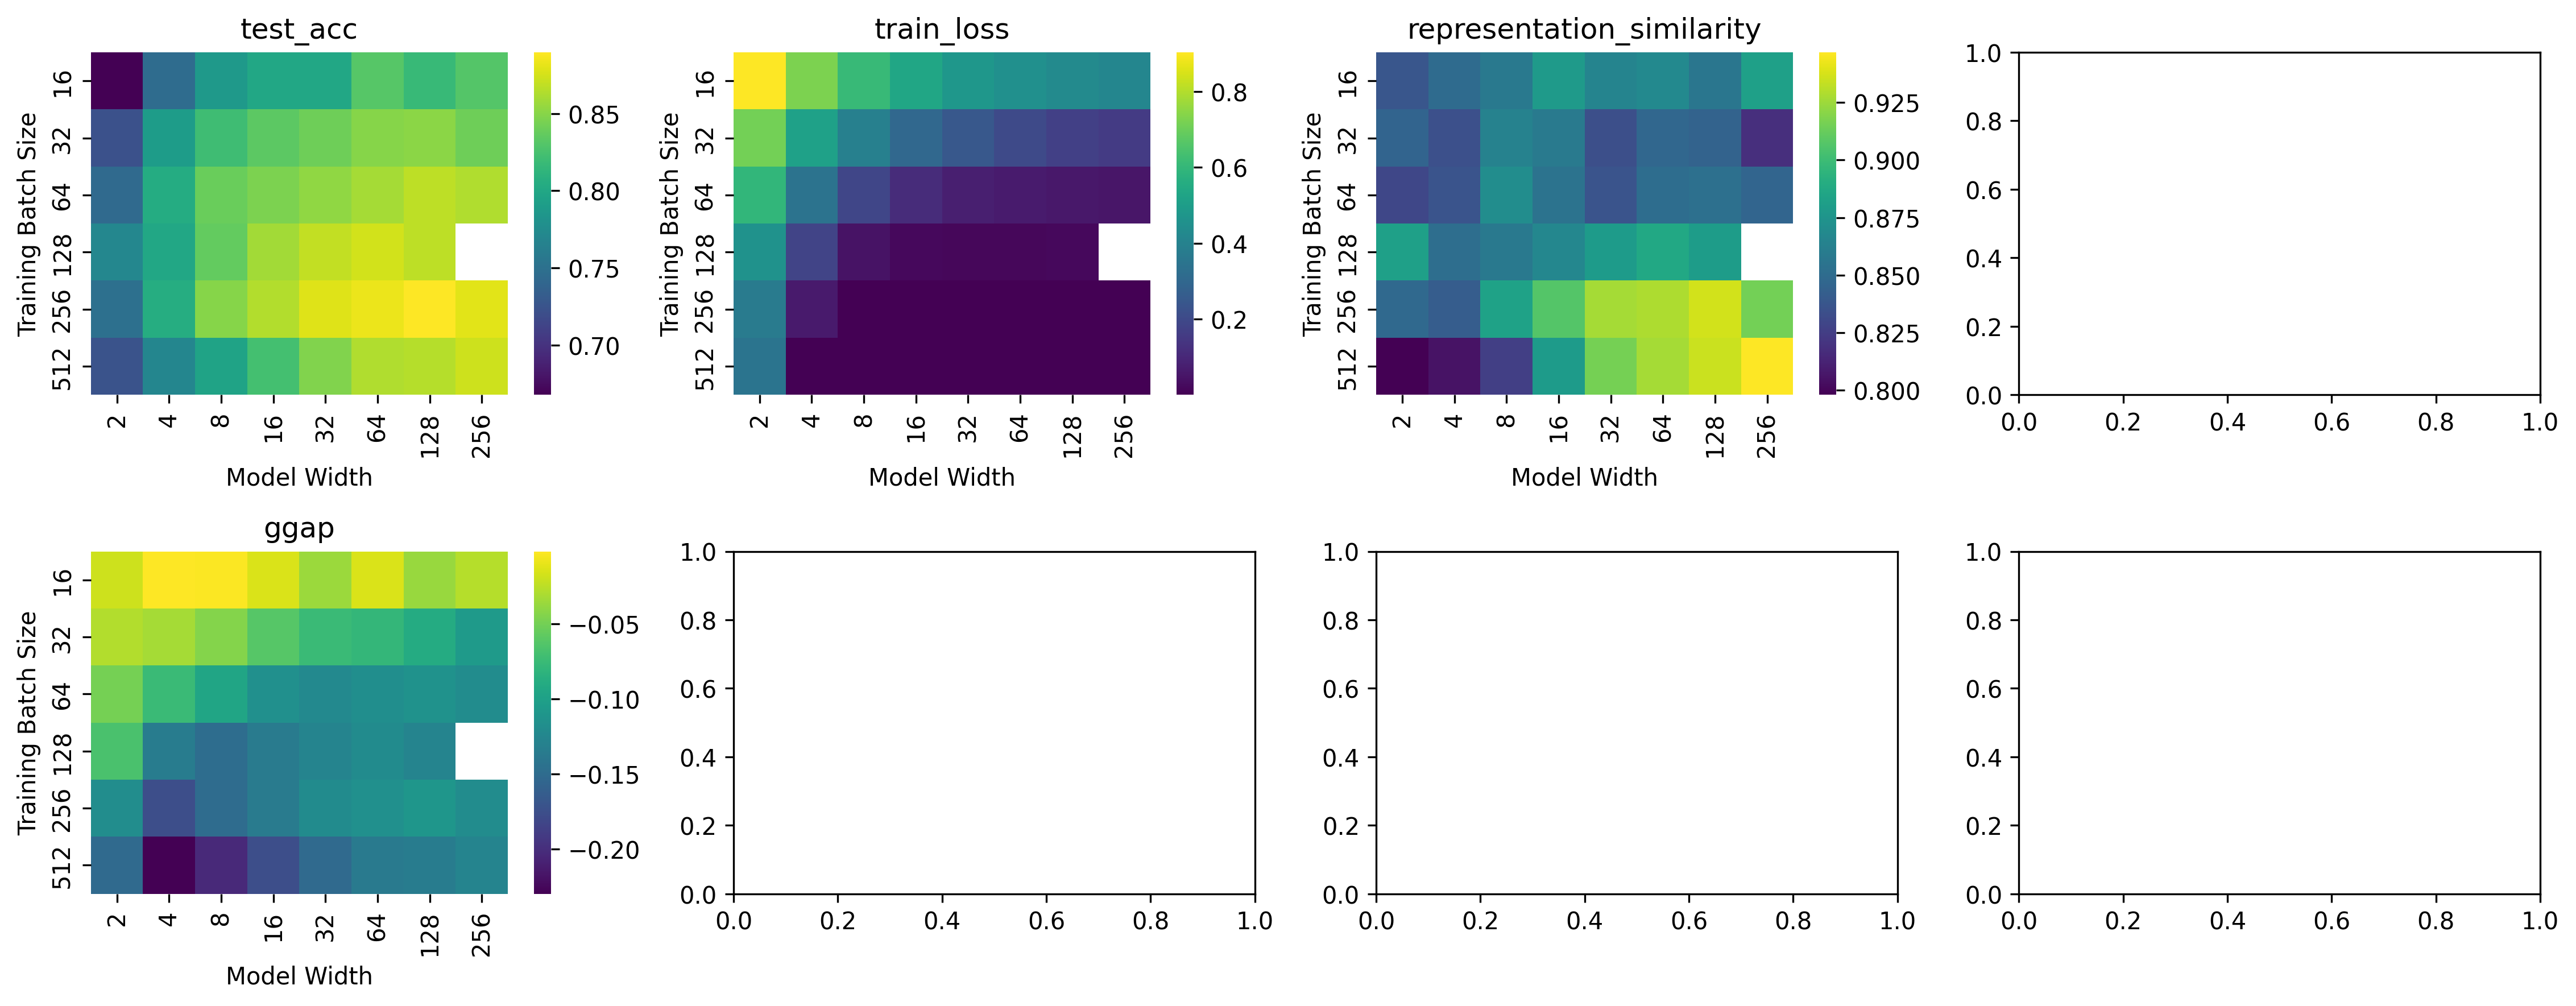

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# fig_list = ["test_acc","train_loss","ggap","representation_similarity", "log_hessian_top_ev","log_hessian_trace",'curve_mc_train_error', 'curve_mc_test_error','wiseft_acc_train_delta','wiseft_acc_test_delta']
# fig_list = ["test_acc","train_loss","ggap","representation_similarity", "log_hessian_top_ev","log_hessian_trace",'curve_mc_train_error','wiseft_acc_test_delta']
# fig_list = [["test_acc","ggap"],["train_loss",'curve_mc_train_error'],["log_hessian_top_ev","representation_similarity"],[ "log_hessian_trace",'wiseft_acc_test_delta']]
# fig_list = [["test_acc","ggap"],["train_loss",],["log_hessian_top_ev","representation_similarity"],[ "log_hessian_trace",'wiseft_acc_test_delta']]
fig_list = [["test_acc","ggap"],["train_loss",],["representation_similarity"],[ ]]

centered = ['curve_mc_train_error', 'curve_mc_test_error']

num_cols = 4
num_plots = len(fig_list)
num_rows = len(fig_list[0])



fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows,figsize=(3.8*num_cols,3*num_rows),dpi=300)


for idx,fig_keys in enumerate(fig_list):
    for jdx,fig_key in enumerate(fig_keys):
        df_fig = df_merged.pivot_table(index='training::batchsize', columns='model::width', values=fig_key)
    
        # Create the heatmap
        adx = ax[jdx,idx]
    
        if fig_key in centered:
            sns.heatmap(df_fig, annot=False, cmap='RdBu', center=0, cbar=True,ax=adx)
        else:
            sns.heatmap(df_fig, annot=False, cmap='viridis', cbar=True,ax=adx)
        adx.set_title(f'{fig_key}')
        adx.set_xlabel('Model Width')
        adx.set_ylabel('Training Batch Size')

fig.tight_layout()
plt.show()


In [9]:
config_curve = compile_configs(root_curve,0)
config_curve.keys()

Index(['individual', 'aggregated', 'done', 'training_iteration', 'trial_id',
       'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid',
       'hostname', 'node_ip', 'time_since_restore', 'iterations_since_restore',
       'model_paths', 'epoch', 'curve::num_points', 'curve::num_bends',
       'curve::fix_start', 'curve::fix_end', 'curve::lr',
       'curve::weight_decay', 'curve::momentum', 'curve::epochs',
       'curve::batchsize', 'wandb', 'resources', 'file_path'],
      dtype='object')

In [ ]:
config_curve

In [12]:
config_curve.aggregated.tolist()[0]['mc'].keys()
# min max mean int

dict_keys(['train_loss', 'test_loss', 'train_error', 'test_error'])

In [16]:
df_curve = unroll_curve_dict(config_curve,"aggregated")
df_curve.keys()

Index(['individual', 'aggregated', 'done', 'training_iteration', 'trial_id',
       'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid',
       'hostname', 'node_ip', 'time_since_restore', 'iterations_since_restore',
       'model_paths', 'epoch', 'curve::num_points', 'curve::num_bends',
       'curve::fix_start', 'curve::fix_end', 'curve::lr',
       'curve::weight_decay', 'curve::momentum', 'curve::epochs',
       'curve::batchsize', 'wandb', 'resources', 'file_path', 'mc_train_loss',
       'mc_test_loss', 'mc_train_error', 'mc_test_error'],
      dtype='object')

In [17]:
# get aggregated data

# clean df
keys_to_retain_curve = [
       'model_paths', 'epoch', 'file_path', 'mc_train_loss',
       'mc_test_loss', 'mc_train_error', 'mc_test_error']
data_curve = df_curve[keys_to_retain_curve].copy()    
new_names = {}
for key in data_curve.keys():
    if key=='model_paths':
        continue
    new_names[key]=f'curve_{key}'
data_curve.rename(columns=new_names,inplace=True)
data_curve

,model_paths,curve_epoch,curve_file_path,curve_mc_train_loss,curve_mc_test_loss,curve_mc_train_error,curve_mc_test_error
0,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-1.615162,1.312973,-48.225333,5.653333
1,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.331795,0.171138,-10.712000,-4.608333
2,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.959157,0.301628,-24.705333,4.528333
3,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.451449,-0.177726,-3.538667,0.661667
4,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-1.029729,0.160064,-30.912333,-9.480000
5,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-1.163683,0.640620,-33.153000,2.033333
6,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.584269,-0.446935,-0.251333,-2.438333
7,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.245892,0.380048,-1.610667,7.946667
8,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.442764,-0.365104,-1.703333,-3.150000
9,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.667373,-0.478878,-0.162667,-2.223333


In [24]:
config_df = compile_configs(root_zoo,150)
# clean exp config
keys_to_retain_exp = ['train_loss', 'train_acc', 'test_loss', 'test_acc',
       'training_iteration', 'model::type','model::width',
       'seed',
       'training::batchsize', 'file_path']
data_df = config_df[keys_to_retain_exp].copy()

data_df["ggap"] = data_df["train_acc"] - data_df["test_acc"]

for key in ["train_loss","test_loss","train_acc","test_acc","ggap"]:
    ddx = data_df[key].to_numpy()
    print(f'{key} - {ddx.mean():2.2f}+-{ddx.std():2.2f} [{ddx.min():2.2f},{ddx.max():2.2f}]')

train_loss - 0.04+-0.09 [0.00,0.52]
test_loss - 0.60+-0.30 [0.27,1.69]
train_acc - 0.99+-0.03 [0.82,1.00]
test_acc - 0.84+-0.07 [0.64,0.92]
ggap - 0.15+-0.06 [0.05,0.33]
